# Preprocessing UCSF PDGM dataset
Okay everyone, let's do this one last time!

The goal of this file is to create tfrecord files of the UCSF PDGM dataset, that can be used for training. The result should be tfrecord files for each leasion with a label indication what kind of tumor is visible in the leasion.

Link to download: https://www.cancerimagingarchive.net/collection/ucsf-pdgm/

Citation: Evan Calabrese, Javier E Villanueva-Meyer, Jeffrey D Rudie, Andreas M Rauschecker,
Ujjwal Baid, Spyridon Bakas, Soonmee Cha, John T Mongan, and Christopher P Hess.
The university of california san francisco preoperative diffuse glioma mri dataset. Radiology: Artificial Intelligence, 4(6):e220058, 2022.

Infos about the dataset:
- the dataset contains preoperative images of diffuse gliomas
- age and sex are technically included, so is other information, but I don't think I'll be need it

The dataset structure looks like this:
```
path_to_ucsf_pdgm_dataset_folder
│
│__UCSF-PDGM-0004_nifti
    │
    │__UCSF-PDGM-0004_T1.nii.gz
    │__UCSF-PDGM-0004_T1c.nii.gz
    │__UCSF-PDGM-0004_T2.nii.gz
    │__UCSF-PDGM-0004_FLAIR.nii.gz
    │__UCSF-PDGM-0004_tumor_segmentation.nii.gz
    ...
│
│__UCSF-PDGM-0004_nifti
...
```

In [ ]:
# TO-DO:
# [ ] Get overview of dataset
# [ ] Rotate images 90 degress and percentile normalize them
# [ ] Create png images of the largest visible tumor slice in each scan
# [ ] Combine the four sequences and the segmentation mask into a single tfrecord file
# [ ] Profit?

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pathlib import Path
import random
import nibabel as nib

In [80]:
path_to_ucsf_pdgm_dataset_folder = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM-v3')
path_to_ucsf_pdgm_metadata_glossary = '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM-metadata_glossary.csv'
path_to_ucsf_pdgm_metadata = '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM-metadata_v2.csv'
path_to_ucsf_pdgm_png_slices = '/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM_slices'
path_to_ucsf_pdgm_tfrs = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM_tfrs')

path_to_ucsf_pdgm_rgb_tfrs = path_to_ucsf_pdgm_tfrs / 'rgb_tfrs'
path_to_ucsf_pdgm_gray_tfrs = path_to_ucsf_pdgm_tfrs / 'gray_tfrs'

IMG_SIZE = 240

In [4]:
# create custom class for each patient to store all relevant information

class Patient:
    def __init__(self, id):
        self.id = id

        self.t1 = None # Path to T1 image
        self.t1c = None # Path to T1c image
        self.t2 = None # Path to T2 image
        self.flair = None # Path to FLAIR image

        self.tumor_segmentation = None # Path to tumor segmentation mask

## Get Overview of Dataset

In [5]:
ucsf_metadata = pd.read_csv(path_to_ucsf_pdgm_metadata)
ucsf_metadata.head()

,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,M,66,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,F,80,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,M,70,4,"Glioblastoma, IDH-wildtype",indeterminate,NaN,NaN,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,M,70,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,F,68,4,"Glioblastoma, IDH-wildtype",negative,0.0,NaN,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training


In [37]:
different_pathologies = ucsf_metadata['Final pathologic diagnosis (WHO 2021)'].value_counts()
different_pathologies

Final pathologic diagnosis (WHO 2021)
Glioblastoma, IDH-wildtype                         374
Astrocytoma, IDH-mutant                             90
Astrocytoma, IDH-wildtype                           24
Oligodendroglioma, IDH-mutant, 1p/19q-codeleted     13
Name: count, dtype: int64

The labels for the pretraining dataset are going to be:
- 0: Glioblastoma, IDH-wildtype
- 1: Astrocytoma, IDH-wildtype
- 2: Astrocytoma, IDH-mutant
- 3: Oligodendroglioma, IDH-mutant, 1p/19q-codeleted
- 4: brain metastases

## Clean up dataset IDs

In [42]:
patient_ids_metadata = list(ucsf_metadata['ID'].unique())
# problem, in the metadata the patient IDs are given with only 3 integers, in the dataset they are given with 4 integers
# solution, add a leading zero to the metadata patient IDs
fixed_patient_ids_metadata = []
for id in patient_ids_metadata:
    num = id.split('-')[2]
    new_num = "0" + num
    id = id.replace(num, new_num)
    fixed_patient_ids_metadata.append(id)

print(f"# of metadata patients: {len(fixed_patient_ids_metadata)}")
print(f"Example patient ID: {fixed_patient_ids_metadata[0]}")

# get dictionary names in path_to_ucsf_pdgm_dataset_folder
patient_ids_dataset = list(path_to_ucsf_pdgm_dataset_folder.iterdir())
# remove folders that start with a "."
patient_ids_dataset = [patient_id for patient_id in patient_ids_dataset if not patient_id.name.startswith('.')]
print(f"# of dataset patients: {len(patient_ids_dataset)}")
patient_ids_dataset = [patient_id.name for patient_id in patient_ids_dataset]
patient_ids_dataset = [
    patient_id.split('_')[0] if patient_id.split('_')[1] == 'nifti' 
    else patient_id.split('_')[0] + patient_id.split('_')[1]
    for patient_id in patient_ids_dataset
]
print(f"Example patient ID: {patient_ids_dataset[0]}")
print()

# get crossover between dataset and metadata
print(f"# of patients in both dataset and metadata: {len(set(patient_ids_dataset).intersection(set(fixed_patient_ids_metadata)))}")
ucsf_patient_ids = list(set(patient_ids_dataset).intersection(set(fixed_patient_ids_metadata)))
print(len(ucsf_patient_ids))
print(f"# of patients in metadata but not in dataset: {len(set(fixed_patient_ids_metadata) - set(patient_ids_dataset))}")
print(set(fixed_patient_ids_metadata) - set(patient_ids_dataset))
print()
print(f"# of patients in dataset but not in metadata: {len(set(patient_ids_dataset) - set(fixed_patient_ids_metadata))}")
print(set(patient_ids_dataset) - set(fixed_patient_ids_metadata))


# of metadata patients: 501
Example patient ID: UCSF-PDGM-0004
# of dataset patients: 501
Example patient ID: UCSF-PDGM-0522

# of patients in both dataset and metadata: 495
495
# of patients in metadata but not in dataset: 6
{'UCSF-PDGM-0138', 'UCSF-PDGM-0278', 'UCSF-PDGM-0289', 'UCSF-PDGM-0315', 'UCSF-PDGM-0175', 'UCSF-PDGM-0181'}

# of patients in dataset but not in metadata: 6
{'UCSF-PDGM-0429FU003d', 'UCSF-PDGM-0433FU007d', 'UCSF-PDGM-0396FU175d', 'UCSF-PDGM-0409FU001d', 'UCSF-PDGM-0391FU016d', 'UCSF-PDGM-0431FU001d'}


In [77]:
# create array of patient_ids and their pathology
patient_ids_and_pathologies = {}
for patient_id in ucsf_patient_ids:
    # remove first 0 from ucsf_patient_ids to match metadata
    # metadata id: UCSF-PDGM-398
    # dataset id: UCSF-PDGM-0398_nifti
    # adjust accordingly
    patient_number = patient_id.split('-')[2][1:]
    #print(patient_number)
    new_patient_id = f"UCSF-PDGM-{patient_number}"

    pathology = list(ucsf_metadata[ucsf_metadata['ID'] == new_patient_id]['Final pathologic diagnosis (WHO 2021)'])[0]
    #print(pathology)
    patient_ids_and_pathologies[patient_id] = pathology

# turn pathologies into numbers
# 0: Glioblastoma, IDH-wildtype
# 1: Astrocytoma, IDH-wildtype
# 2: Astrocytoma, IDH-mutant
# 3: Oligodendroglioma, IDH-mutant, 1p/19q-codeleted
for patient_id in patient_ids_and_pathologies:
    if patient_ids_and_pathologies[patient_id] == 'Glioblastoma, IDH-wildtype':
        patient_ids_and_pathologies[patient_id] = 0
    elif patient_ids_and_pathologies[patient_id] == 'Astrocytoma, IDH-wildtype':
        patient_ids_and_pathologies[patient_id] = 1
    elif patient_ids_and_pathologies[patient_id] == 'Astrocytoma, IDH-mutant':
        patient_ids_and_pathologies[patient_id] = 2
    elif patient_ids_and_pathologies[patient_id] == 'Oligodendroglioma, IDH-mutant, 1p/19q-codeleted':
        patient_ids_and_pathologies[patient_id] = 3

print(patient_ids_and_pathologies)


{'UCSF-PDGM-0540': 3, 'UCSF-PDGM-0522': 0, 'UCSF-PDGM-0072': 0, 'UCSF-PDGM-0214': 0, 'UCSF-PDGM-0170': 0, 'UCSF-PDGM-0167': 0, 'UCSF-PDGM-0112': 0, 'UCSF-PDGM-0279': 0, 'UCSF-PDGM-0344': 0, 'UCSF-PDGM-0108': 2, 'UCSF-PDGM-0111': 0, 'UCSF-PDGM-0070': 0, 'UCSF-PDGM-0191': 0, 'UCSF-PDGM-0478': 2, 'UCSF-PDGM-0277': 1, 'UCSF-PDGM-0534': 0, 'UCSF-PDGM-0159': 0, 'UCSF-PDGM-0023': 0, 'UCSF-PDGM-0229': 0, 'UCSF-PDGM-0342': 0, 'UCSF-PDGM-0223': 0, 'UCSF-PDGM-0404': 0, 'UCSF-PDGM-0468': 2, 'UCSF-PDGM-0235': 2, 'UCSF-PDGM-0136': 0, 'UCSF-PDGM-0329': 0, 'UCSF-PDGM-0140': 0, 'UCSF-PDGM-0238': 2, 'UCSF-PDGM-0362': 0, 'UCSF-PDGM-0423': 0, 'UCSF-PDGM-0397': 0, 'UCSF-PDGM-0405': 0, 'UCSF-PDGM-0119': 2, 'UCSF-PDGM-0388': 0, 'UCSF-PDGM-0487': 0, 'UCSF-PDGM-0453': 0, 'UCSF-PDGM-0009': 0, 'UCSF-PDGM-0303': 2, 'UCSF-PDGM-0010': 0, 'UCSF-PDGM-0370': 0, 'UCSF-PDGM-0040': 0, 'UCSF-PDGM-0095': 0, 'UCSF-PDGM-0210': 0, 'UCSF-PDGM-0091': 0, 'UCSF-PDGM-0018': 0, 'UCSF-PDGM-0411': 0, 'UCSF-PDGM-0334': 0, 'UCSF-PDGM-0

## Get Nifti and Segmentation Files for the IDs

In [44]:
all_patients = []
patients_with_missing_data = []

# loop through ids and create patient objects
for id in tqdm(ucsf_patient_ids):
    patient = Patient(id)
    path_to_t1 = path_to_ucsf_pdgm_dataset_folder / f'{id}_nifti' / f'{id}_T1.nii.gz'
    path_to_t1c = path_to_ucsf_pdgm_dataset_folder / f'{id}_nifti' / f'{id}_T1c.nii.gz'
    path_to_t2 = path_to_ucsf_pdgm_dataset_folder / f'{id}_nifti' / f'{id}_T2.nii.gz'
    path_to_flair = path_to_ucsf_pdgm_dataset_folder / f'{id}_nifti' / f'{id}_FLAIR.nii.gz'
    path_to_segmentation = path_to_ucsf_pdgm_dataset_folder / f'{id}_nifti' / f'{id}_tumor_segmentation.nii.gz'

    paths_to_files = [path_to_t1, path_to_t1c, path_to_t2, path_to_flair, path_to_segmentation]

    for path in paths_to_files:
        if not path.is_file():
            patients_with_missing_data.append(id)
            print(f"{path} for patient {id} does not exist")
            continue
    
    if id in patients_with_missing_data:
        continue

    patient.t1 = path_to_t1
    patient.t1c = path_to_t1c
    patient.t2 = path_to_t2
    patient.flair = path_to_flair
    patient.tumor_segmentation = path_to_segmentation

    all_patients.append(patient)


100%|██████████| 495/495 [00:00<00:00, 3285.30it/s]


In [45]:
print(f"# of all patients: {len(all_patients)}")
print(f"# of patients with missing data: {len(patients_with_missing_data)}")

# of all patients: 495
# of patients with missing data: 0


Display 9 random images from all patients including the segmentations

In [46]:
def visualize_random_patients(all_patients):

    # Funktion zum Laden und Anzeigen eines NIfTI-Bildes
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # 9 zufällige Patienten auswählen
    random_patients = random.sample(all_patients, 9)

    # 3x3 Grafik erstellen
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        
        # Zufällige MRT Sequenz auswählen
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        
        # MRT Bild laden
        image = load_nifti_image(sequence_path)
        
        # Segmentierung laden
        segmentation = load_nifti_image(patient.tumor_segmentation)
        
        # Größte sichtbare Tumorschicht finden
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # MRT Bild anzeigen
        ax.imshow(image[:, :, slice_index], cmap = 'gray')
        
        # Segmentierung farblich darüber legen
        ax.imshow(segmentation[:, :, slice_index], cmap='Reds', alpha=0.5)
        
        ax.axis('off')

        # Title
        max_value = np.max(image)
        mean_value = np.mean(image)
        min_value = np.min(image)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

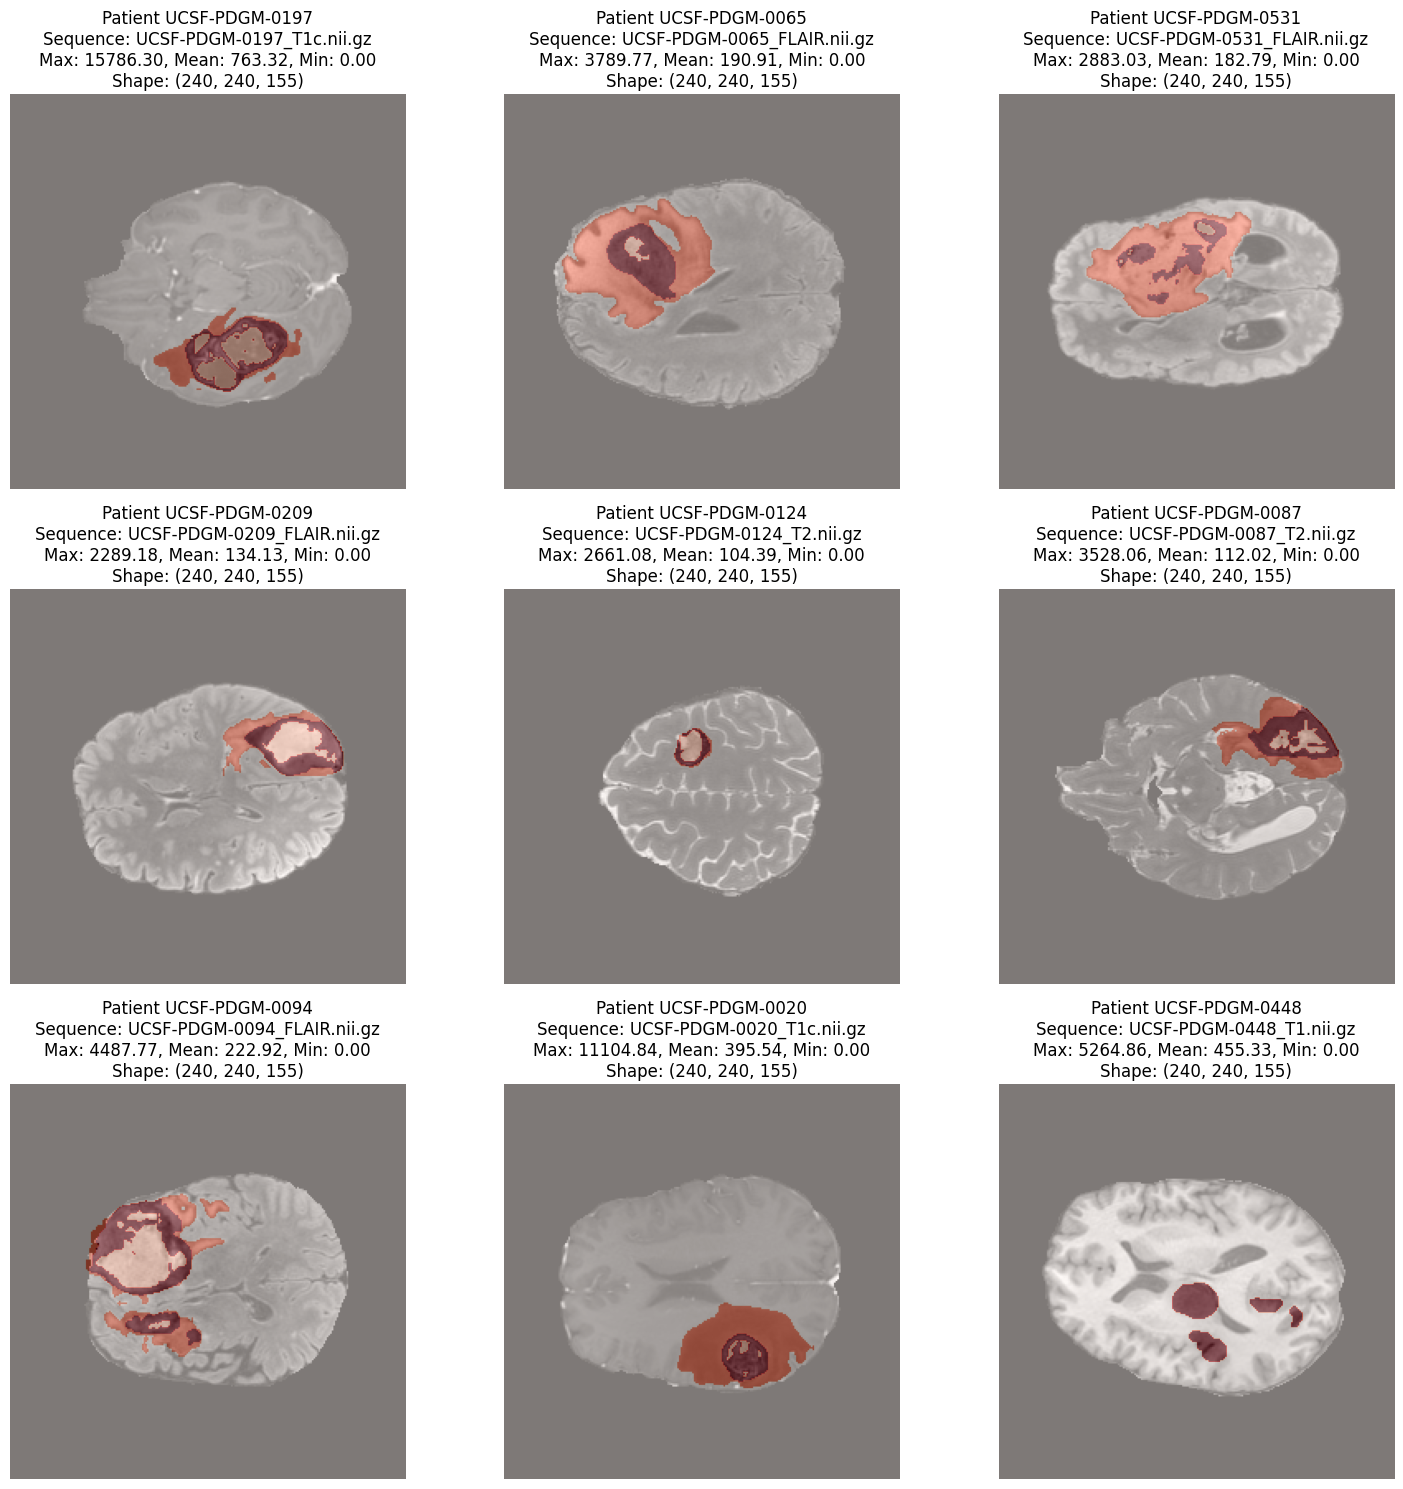

In [52]:
visualize_random_patients(all_patients)

## Image Rotation and Normalization

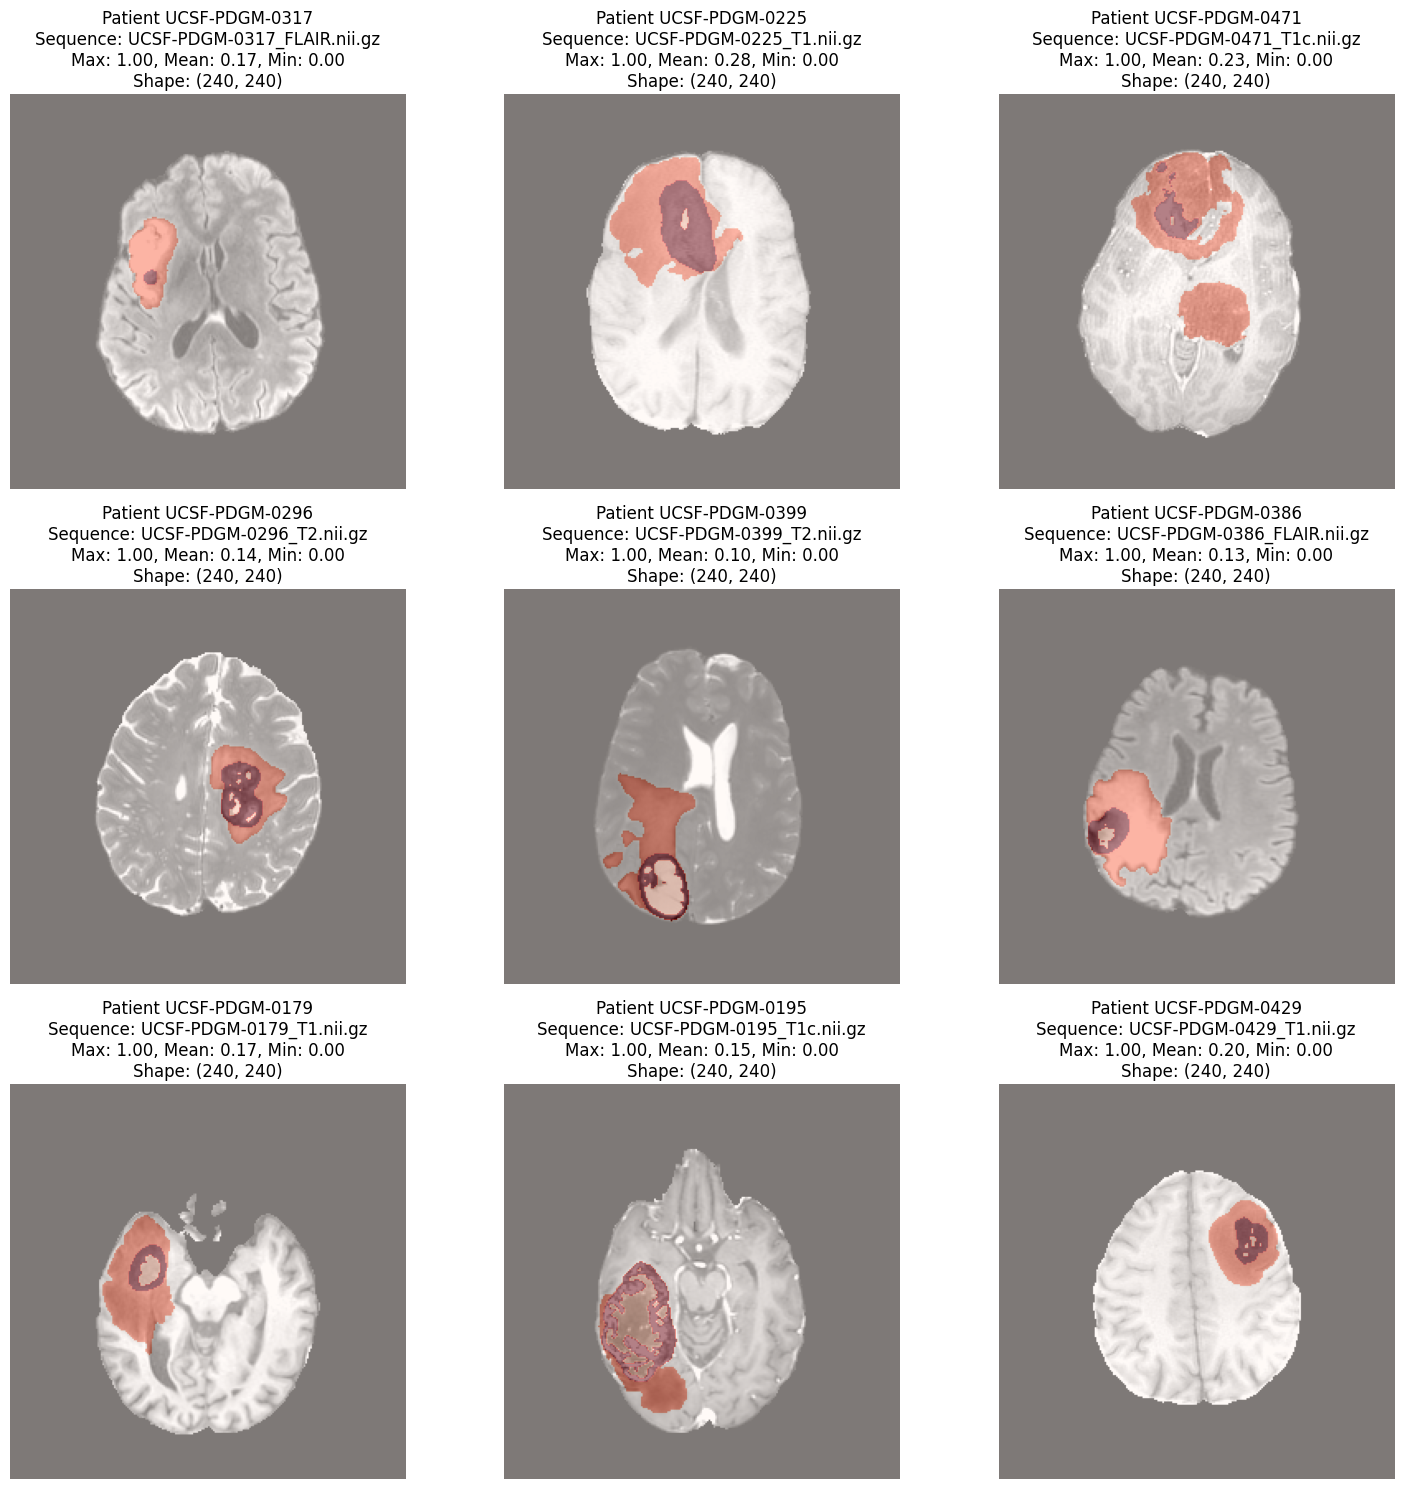

In [59]:
def rotate_and_normalize(image):
    # Rotate the image 90 degrees
    rotated_image = np.rot90(image, k=-1)
    
    # Percentile normalization
    lower_percentile = np.percentile(rotated_image, 1)
    upper_percentile = np.percentile(rotated_image, 99)

    range_val = upper_percentile - lower_percentile

    normalized_image = np.clip(rotated_image, lower_percentile, upper_percentile)
    normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
    
    return normalized_image

def visualize_random_patients_rotated_normalized(all_patients):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    random_patients = random.sample(all_patients, 9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        image = load_nifti_image(sequence_path)
        segmentation = load_nifti_image(patient.tumor_segmentation)
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # Rotate and normalize the image and segmentation
        image_rotated_normalized = rotate_and_normalize(image[:, :, slice_index])
        segmentation_rotated = np.rot90(segmentation[:, :, slice_index], k=-1)
        
        ax.imshow(image_rotated_normalized, cmap='gray', alpha = 1)
        ax.imshow(segmentation_rotated, cmap='Reds', alpha=0.5)
        ax.axis('off')

        max_value = np.max(image_rotated_normalized)
        mean_value = np.mean(image_rotated_normalized)
        min_value = np.min(image_rotated_normalized)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image_rotated_normalized.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

visualize_random_patients_rotated_normalized(all_patients)

## Save images with largest slice as png

In [49]:
def show_segmentation_classes(patient):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    segmentation = load_nifti_image(patient.tumor_segmentation)
    unique_classes = np.unique(segmentation)
    
    print(f"Unique segmentation classes for patient {patient.id}: {unique_classes}")

# Example usage for a random patient
random_patient = random.choice(all_patients)
show_segmentation_classes(random_patient)

Unique segmentation classes for patient UCSF-PDGM-0061: [0. 1. 2. 4.]


I think the segmentations are classified like this:\
0 = normal\
1 = necrosis\
2 = edema\
4 = solid

I will combine 1 and 4 and focus on this combination

In [83]:
def save_largest_tumor_slice(patient, output_folder):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # Load segmentation and find the slice with the largest area of segmentation class 4
    segmentation = load_nifti_image(patient.tumor_segmentation)
    slice_index = np.argmax(np.sum((segmentation == 1) | (segmentation == 4), axis=(0, 1)))

    # Create output directory for the patient
    patient_output_folder = Path(output_folder) / patient.id
    patient_output_folder.mkdir(parents=True, exist_ok=True)

    # Save each sequence and the segmentation mask as PNG
    sequences = {
        't1': patient.t1,
        't1c': patient.t1c,
        't2': patient.t2,
        'flair': patient.flair
    }

    for sequence_name, sequence_path in sequences.items():
        if sequence_path is not None:
            image = load_nifti_image(sequence_path)
            image_slice = image[:, :, slice_index]
            image_rotated_normalized = rotate_and_normalize(image_slice)
            plt.imsave(patient_output_folder / f'{patient.id}_{sequence_name}.png', image_rotated_normalized, cmap='gray')

    # Save the segmentation mask
    segmentation_slice = segmentation[:, :, slice_index]
    segmentation_mask = ((segmentation_slice == 1) | (segmentation_slice == 4)).astype(np.uint8)  # Create a binary mask for class 4
    segmentation_rotated = np.rot90(segmentation_mask, k=-1)
    plt.imsave(patient_output_folder / f'{patient.id}_mask.png', segmentation_rotated, cmap='gray')

# Save largest tumor slice for all patients
for patient in tqdm(all_patients):
    save_largest_tumor_slice(patient, path_to_ucsf_pdgm_png_slices)

  0%|          | 0/495 [00:00<?, ?it/s]/var/folders/by/b05bkcn50tb0fx4h3hhz0h800000gn/T/ipykernel_21021/1685630146.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
/var/folders/by/b05bkcn50tb0fx4h3hhz0h800000gn/T/ipykernel_21021/1685630146.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
/var/folders/by/b05bkcn50tb0fx4h3hhz0h800000gn/T/ipykernel_21021/1685630146.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
/var/folders/by/b05bkcn50tb0fx4h3hhz0h800000gn/T/ipykernel_21021/1685630146.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
  3%|▎         | 13/495 [

All those warnings are caused, because python tries to divide by zeros, when the difference between the upper and lower percentile of the images is 0

Check if each folder contains 5 png files

In [84]:
def check_png_files_in_folder(folder_path):
    # Get all subfolders in the main folder
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

    # Check each subfolder for the number of PNG files
    for subfolder in subfolders:
        png_files = [f for f in os.listdir(subfolder) if f.endswith('.png')]
        if len(png_files) != 5:
            print(f"Subfolder {subfolder} contains {len(png_files)} PNG files instead of 5.")

# Check the path_to_upenn_png_slices folder
check_png_files_in_folder(path_to_ucsf_pdgm_png_slices)

## Create TFRecord Files for patients

In [85]:
def serialize_example(image, label):
    """
    image: A NumPy array containing the image (could be shape (H, W, 5) or (H, W, 3, 5))
    label: Integer label (you can adapt this to your actual label)
    """
    # If 'image' is already a NumPy array, just flatten it:
    image_flattened = image.ravel()

    # Create a tf.train.Example
    tumor_example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_flattened)),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
        )
    )
    return tumor_example.SerializeToString()

def write_patient_to_tfrecord(
    patient_id,
    patient_folder,
    tfrecord_folder,
    label=0,
    is_rgb=False,
    compression_type="GZIP"
):
    """
    patient_id: Unique identifier for the patient (string or int).
    patient_folder: Path to the folder containing the 5 PNG images (T1, T1c, T2, Flair, mask).
    tfrecord_folder: Output folder for the TFRecord file.
    label: A label (int) for the example, can be adapted to your classification task.
    is_rgb: Whether to replicate each 2D slice into 3 channels. 
            - If False -> shape (H, W, 5)
            - If True  -> shape (H, W, 3, 5)
    """
    # Ensure output folder exists
    tfrecord_folder = Path(tfrecord_folder)
    tfrecord_folder.mkdir(parents=True, exist_ok=True)

    # Define the order of sequences you want to load
    sequence_names = ['t1', 't1c', 't2', 'flair', 'mask']

    # Gather all 5 images
    images = []
    for seq_name in sequence_names:
        png_path = Path(patient_folder) / f'{patient_id}_{seq_name}.png'
        if not png_path.exists():
            raise FileNotFoundError(f"Expected file {png_path} not found for patient {patient_id}")
        
        # Read in grayscale (single channel)
        # Resulting shape => (H, W)
        img = cv2.imread(str(png_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"cv2 could not read the file: {png_path}")
        
        # resize image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Convert to float32
        img = img.astype(np.float32)

        # If is_rgb=True, replicate the single channel to 3 channels
        # final shape => (H, W, 3)
        if is_rgb:
            img = np.stack([img, img, img], axis=-1)  # (H, W, 3)

        images.append(img)

    # Stack the 5 images along a new axis
    if is_rgb:
        # images is a list of 5 items, each (H, W, 3)
        # final shape => (H, W, 3, 5)
        final_image = np.stack(images, axis=-1)
    else:
        # images is a list of 5 items, each (H, W)
        # final shape => (H, W, 5)
        final_image = np.stack(images, axis=-1)

    # Write one example to a TFRecord
    tfrecord_filename = tfrecord_folder / f"{patient_id}.tfrecord"
    options = tf.io.TFRecordOptions(compression_type=compression_type)
    with tf.io.TFRecordWriter(str(tfrecord_filename), options=options) as writer:
        # Create a single Example for this patient
        example = serialize_example(final_image, label)
        writer.write(example)

    #print(f"Saved TFRecord for patient {patient_id} at {tfrecord_filename}")

def create_tfrecords_for_all_patients(
    png_root_folder,
    tfrecord_folder,
    labels_dict=None,
    is_rgb=False
):
    """
    Loop over all patients, read their 5 PNG slices, 
    and write one TFRecord file per patient.
    
    png_root_folder: The folder where each patient's subfolder is located.
                     Inside each subfolder there should be 5 PNG images.
    tfrecord_folder: Output folder for the TFRecord files.
    patient_ids: List or iterable of patient IDs (strings or ints).
    labels_dict: A dictionary mapping patient_id -> label. If None, default label=0.
    is_rgb: Whether to replicate each 2D slice into 3 channels. 
    """

    patient_ids = [
        f.name for f in Path(png_root_folder).iterdir()
        if f.is_dir()
    ]

    for pid in tqdm(patient_ids):
        patient_folder = Path(png_root_folder) / str(pid)
        
        # if a labels_dict is provided, fetch the label, else default to 0
        label = labels_dict[pid] if (labels_dict is not None and pid in labels_dict) else 0
        
        write_patient_to_tfrecord(
            patient_id=pid,
            patient_folder=patient_folder,
            tfrecord_folder=tfrecord_folder,
            label=label,
            is_rgb=is_rgb
        )


In [86]:
os.makedirs(path_to_ucsf_pdgm_rgb_tfrs, exist_ok=True)
os.makedirs(path_to_ucsf_pdgm_gray_tfrs, exist_ok=True)

# Create TFRecords in grayscale mode:
create_tfrecords_for_all_patients(
    png_root_folder=path_to_ucsf_pdgm_png_slices,
    tfrecord_folder=path_to_ucsf_pdgm_gray_tfrs,
    is_rgb=False,
    labels_dict=patient_ids_and_pathologies
)

# Optionally create TFRecords in RGB mode:
create_tfrecords_for_all_patients(
    png_root_folder=path_to_ucsf_pdgm_png_slices,
    tfrecord_folder=path_to_ucsf_pdgm_rgb_tfrs,
    is_rgb=True,
    labels_dict=patient_ids_and_pathologies
)

100%|██████████| 495/495 [01:08<00:00,  7.23it/s]


## Read TFRecord files

Label: 0
(240, 240, 3, 5)


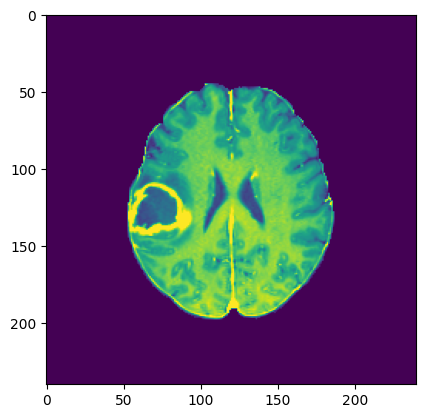

In [98]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM_tfrs/rgb_tfrs/UCSF-PDGM-0152.tfrecord"
rgb = True

num_images = 5 # 4 sequences + 1 mask

image_shape = []

if rgb: # rgb images need three channels
    image_shape = [240, 240, 3, num_images]
else: # gray scale images don't
    image_shape = [240, 240, num_images]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)

    image = example["image"]
    image = tf.reshape(image, image_shape)
    
    return image, example["label"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, label in test_image:
    print(f"Label: {label.numpy()}")
    numpy_image = image.numpy()
    print(numpy_image.shape)
    if rgb:
        plt.imshow(numpy_image[:,:,2,1])
    else:
        plt.imshow(numpy_image[:,:,1])